In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro
import scipy.stats as stats

AB testing is a statistical method used in marketing, product development, and other fields to evaluate the effectiveness of two or more variations of a product or strategy. However, to ensure accurate and reliable results, it is important to ensure that the samples used in AB testing meet certain statistical assumptions. Two key assumptions are normality and homogeneity which will be explained in detail later in the notebook.

But before carrying any tests, we need to check for outliers and perform some EDA

In [2]:
df = pd.read_csv('cookie_cats.csv')

In [22]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [5]:
# Checking for any null values
print(df.isnull().sum())

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


In [8]:
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,49854.0


In [9]:
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


### Checking for outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x201934dbe80>,
 'caps': [<matplotlib.lines.Line2D at 0x201934fc460>,
 'boxes': [<matplotlib.lines.Line2D at 0x201934dbbb0>],
 'medians': [<matplotlib.lines.Line2D at 0x201934fca00>],
 'fliers': [<matplotlib.lines.Line2D at 0x201934fccd0>],
 'means': []}

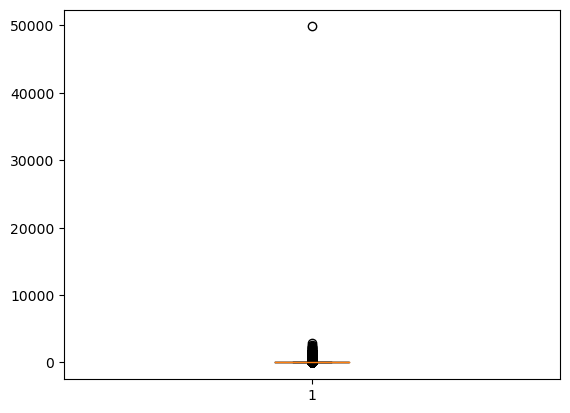

In [13]:
# Checking for outliers
plt.boxplot(df['sum_gamerounds'])

In [25]:
df = df[df['sum_gamerounds']<2000]

{'whiskers': [<matplotlib.lines.Line2D at 0x20193582040>,
 'caps': [<matplotlib.lines.Line2D at 0x20193582610>,
 'boxes': [<matplotlib.lines.Line2D at 0x20193572d30>],
 'medians': [<matplotlib.lines.Line2D at 0x20193582be0>],
 'fliers': [<matplotlib.lines.Line2D at 0x20193582eb0>],
 'means': []}

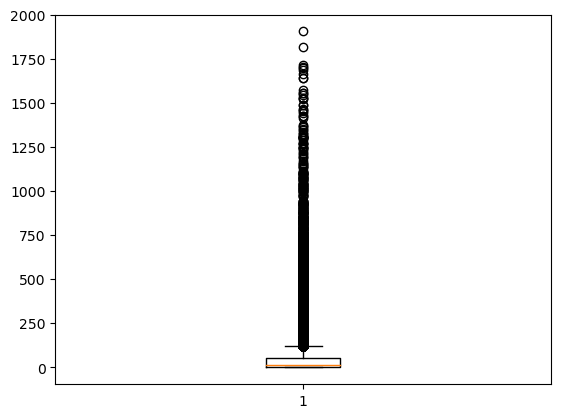

In [26]:
# After removing the outliers
plt.boxplot(df['sum_gamerounds'])

### Analysing the retention rate after 1st day of installing and 7th day

In [30]:
df[df['retention_1'] == False].count()

userid            50035
version           50035
sum_gamerounds    50035
retention_1       50035
retention_7       50035
dtype: int64

In [36]:
retention = df['retention_1'].value_counts()

In [51]:
retention

False    50035
True     40144
Name: retention_1, dtype: int64

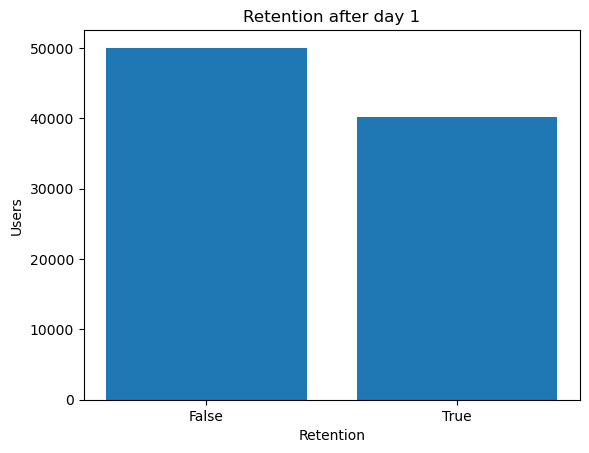

In [52]:
plt.bar(['False', 'True'], retention.values)
plt.xlabel("Retention")
plt.ylabel("Users")
plt.title("Retention after day 1")
plt.show()

We can see that roughly half of the users who installed did not play on the first day. This could mean that the marketing stratergy is working and people are installing the game but are not finding it appealing right away. More measures to make the game beginner friendly andhigher rewards early on could reverse this.

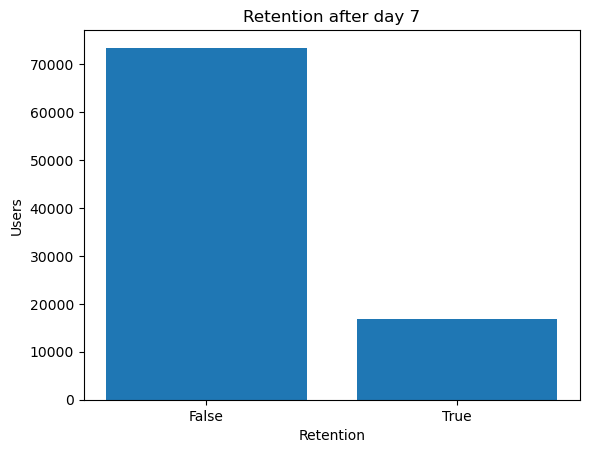

In [53]:
retention7 = df['retention_7'].value_counts()
plt.bar(['False', 'True'], retention7.values)
plt.xlabel("Retention")
plt.ylabel("Users")
plt.title("Retention after day 7")
plt.show()

Retention after 7th day also follows the same trend as people continue to stop playing after using the app for 7 days. More incentives and interesting quests could keep them.

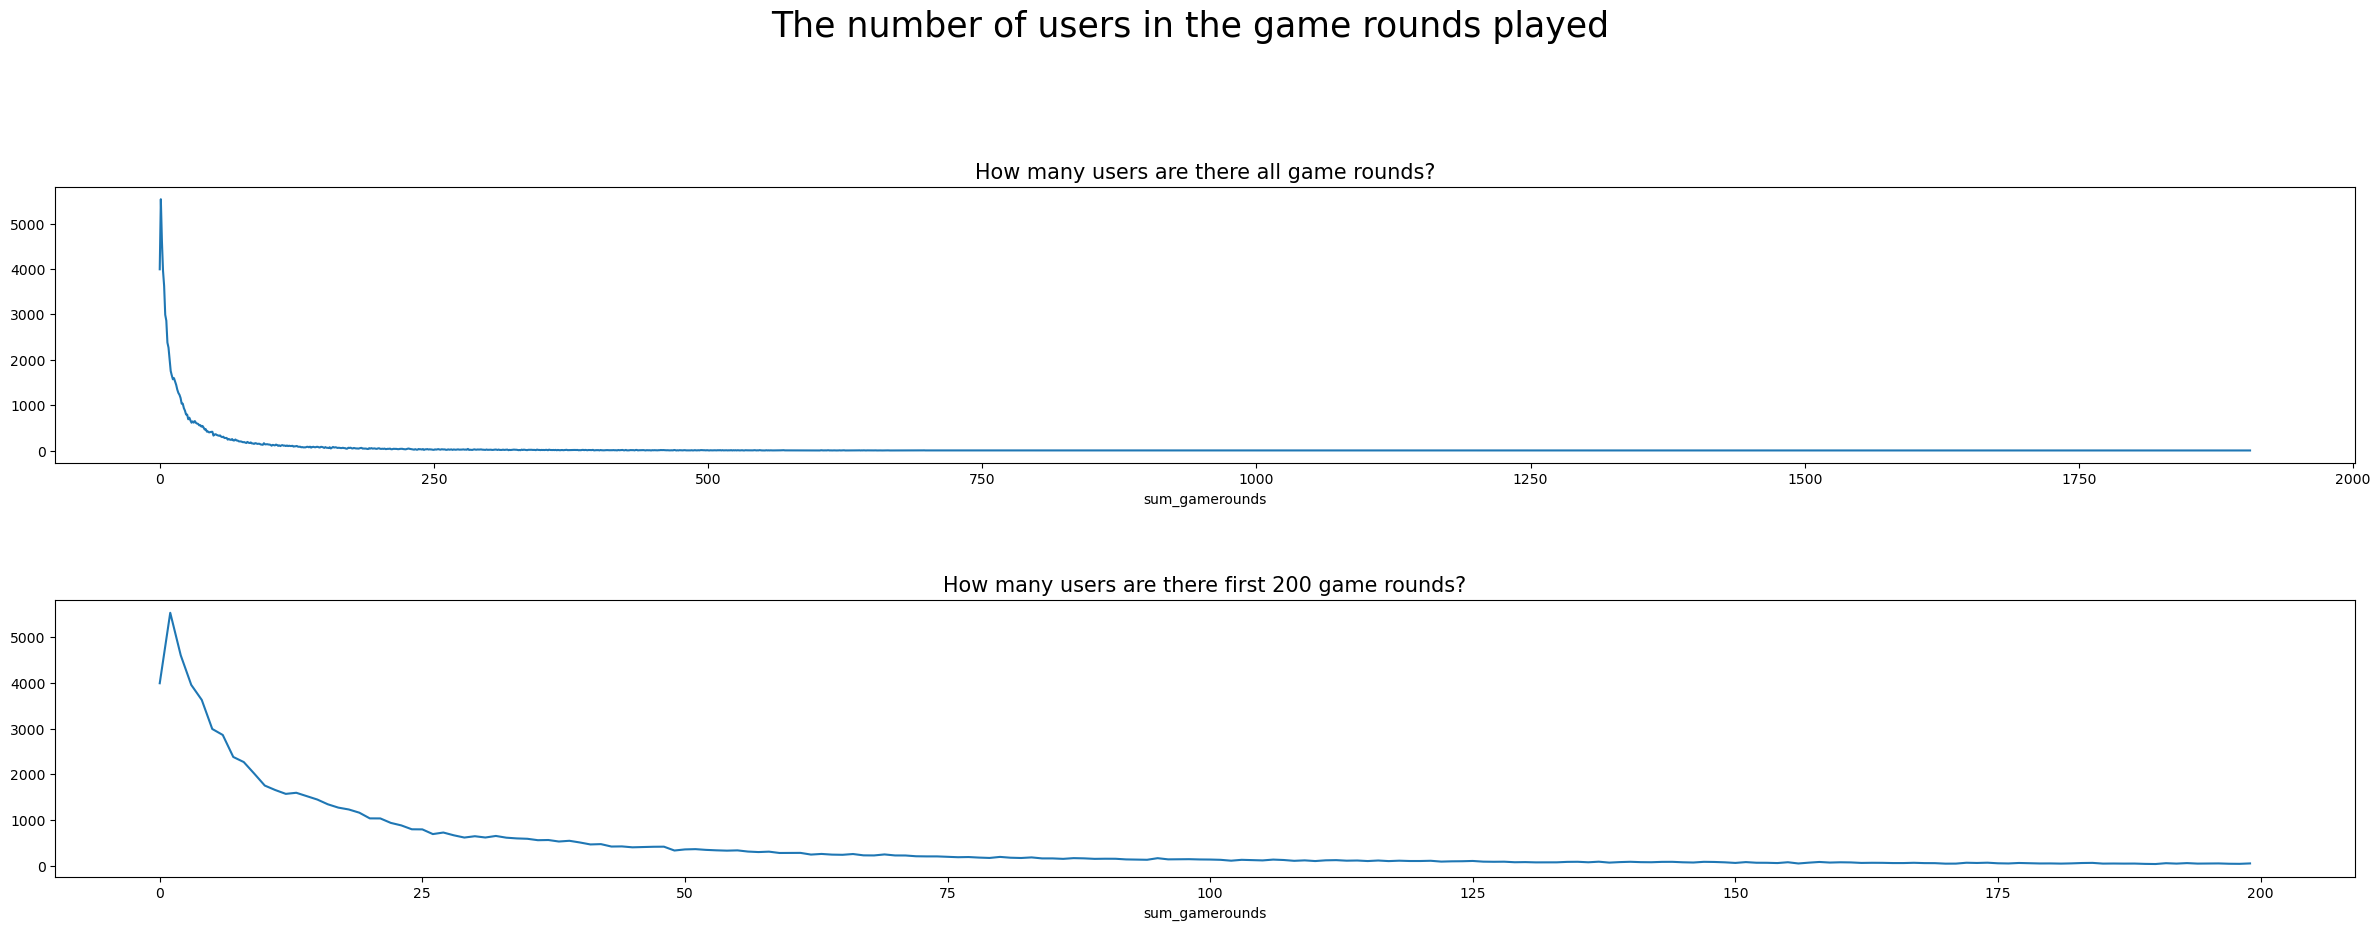

In [55]:
fig, axes = plt.subplots(2, 1, figsize = (25,10))
df.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
df.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout(pad=5);

Number of players after approximately 10 rounds decreases sharply.

In [58]:
df["Retention"] = np.where((df.retention_1 == True) & (df.retention_7 == True), 1,0)
df.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

C:\Users\beelk\AppData\Local\Temp\ipykernel_20544\2675639463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Retention"] = np.where((df.retention_1 == True) & (df.retention_7 == True), 1,0)


count  median        mean         std   max
version Retention                                             
gate_30 0          38023    12.0   28.070273   48.017452  1072
        1           6672   127.0  182.526829  181.208678  1906
gate_40 0          38982    12.0   28.036350   47.106082  1241
        1           6502   133.0  189.092741  188.243607  1816

Normality refers to the distribution of the data being tested. Specifically, it refers to the assumption that the data follows a normal distribution, also known as a bell curve. A normal distribution means that the data is symmetrical around the mean, with most of the data points clustering around the center of the distribution and fewer data points at the tails of the distribution. When data is normally distributed, it is easier to make accurate predictions and inferences about the population being tested.

Homogeneity, on the other hand, refers to the similarity of the variances of the data being tested. Specifically, it refers to the assumption that the variance of the data is equal across all groups being tested. When variances are not equal across groups, this can lead to inaccurate results and incorrect conclusions being drawn from the data.

Both normality and homogeneity are important in AB testing because they help ensure that the results obtained are accurate and reliable. If the data is not normally distributed, then the statistical tests used to analyze the data may not be appropriate, and the results obtained may be inaccurate or misleading. Similarly, if the variances of the data are not equal across all groups being tested, then the statistical tests used to analyze the data may not be appropriate, and the results obtained may be inaccurate or misleading.

In order to ensure that the assumptions of normality and homogeneity are met in AB testing, various statistical tests can be used to assess the data before the actual testing begins. For example, a normal probability plot can be used to visually check whether the data follows a normal distribution. Similarly, a Levene’s test can be used to test whether the variances of the data are equal across all groups being tested.

In summary, normality and homogeneity are important assumptions in AB testing that help ensure that the results obtained are accurate and reliable. By checking for normality and homogeneity before the actual testing begins, researchers can ensure that the statistical tests used to analyze the data are appropriate and that the conclusions drawn from the data are valid.

In [84]:
def ab_testing(df, group_split, control_group, target_group, target_column):
    # splitting the groups
    group_A = df[df[group_split] == control_group][target_column]
    group_B = df[df[group_split] == target_group][target_column]
    # check for normality
    normality_A = shapiro(group_A)[1] < 0.05
    normality_B = shapiro(group_B)[1] < 0.05
    if normality_A == False & normality_B == False: # it's a normal distribution
        # check for homogenity
        test = 'Levene Test'
        levene_test = stats.levene(group_A, group_B)[1] < 0.05
        if levene_test == False: # homogenous
            ttest = stats.ttest_ind(group_A, group_B, equal_var = True)[1]
        else:
            ttest = stats.ttest_ind(groupA, groupB, equal_var = False)[1]
    else: # it's not a normal distribution
        test = 'Mann Whitney U test'
        ttest = stats.mannwhitneyu(group_A, group_B)[1] 
    if ttest < 0.05:
        comment = 'Reject null hypothesis'
    else:
        comment = 'Accept null hypothesis'
    data = [{
        'Test': test,
        'p-value': ttest,
        'Comment': comment
    }]
    results = pd.DataFrame(data)
    return results

In [85]:
ab_testing(df, 'version', 'gate_30', 'gate_40', 'sum_gamerounds')

C:\Users\beelk\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Test,p-value,Comment
0,Mann Whitney U test,0.05023,Accept null hypothesis


Since the p-value is greater than 0.05, we can accept the null hypothesis which was there is no statistical difference between the two versions of the game.